# <center>Regularization</center>

In this assignment, we would like to predict the success of shots made by basketball players in the NBA.

![](https://nthu-datalab.github.io/ml/labs/05_Regularization/fig-nba.png)

Please download the dataset first. You might need to try with various models to achieve better performance.

## Requirements
- Submit to eeclass with your code file `Lab05_{student_id}.ipynb` (e.g. `Lab05_109069999.ipynb`) and prediction file `Lab05_{student_id}_y_pred.csv`. The notebook should contain the following parts:

    1. Use all features to train [any linear model in scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#linear-models) and try different hyperparameters (ex. different degree, complexity). Show their performances.
    2. Select 1 setting (model + hyperparameters) and plot the **error curve** to show that the setting you selected **isn't over-fit**.
    3. Use any method to choose the **best 3 features** that can best aid the model's prediction. Explain **how you find it**.
        - Note: the combination of features doesn't count as 1 feature, e.g. $x_{1}$, $x_{2}$, and $x_1^2+x_2$ count as only two features.
    4. Train the model selected in 2. with the only 3 features selected in 3., and present the training error.
    5. Export the predictions of the model trained in 4. for ``X_test`` (follow the format of ``y_train.csv``).
    6. **A brief report** of what you have done in this assignment.

- Prediction performance will have minimal impact on the assignment grade, so there's no need to be overly concerned about it.
- Deadline: **2023-10-19 (Thur) 23:59**.

## Hints
1. You can **preprocess the data** to help your training.
2. Since you don't have y_test this time, you may need to **split a validation set** for checking your performance.
3. It is possible to use a regression model as a classifier, for example [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html).

## References

1. [Stanford CS229 Machine Learning](http://cs229.stanford.edu/proj2017/final-reports/5132133.pdf)
2. [NBA shot logs](https://www.kaggle.com/dansbecker/nba-shot-logs)


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import urllib.request
import os

os.makedirs("./data", exist_ok=True)

if not os.path.exists("./data/X_train.csv"):
    urllib.request.urlretrieve(
        "https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_train.csv",
        "./data/X_train.csv",
    )
if not os.path.exists("./data/y_train.csv"):
    urllib.request.urlretrieve(
        "https://nthu-datalab.github.io/ml/labs/05_Regularization/data/y_train.csv",
        "./data/y_train.csv",
    )
if not os.path.exists("./data/X_test.csv"):
    urllib.request.urlretrieve(
        "https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_test.csv",
        "./data/X_test.csv",
    )

X = pd.read_csv("./data/X_train.csv")
y = pd.read_csv("./data/y_train.csv")
X_test = pd.read_csv("./data/X_test.csv")

print("X.shape:", X.shape)
print("y.shape:", y.shape)
print("X_test.shape:", X_test.shape)

print("X.columns:", X.columns.values)
print("y.columns:", y.columns.values)

X.shape: (85751, 8)
y.shape: (85751, 1)
X_test.shape: (36751, 8)
X.columns: ['PERIOD' 'GAME_CLOCK' 'SHOT_CLOCK' 'DRIBBLES' 'TOUCH_TIME' 'SHOT_DIST'
 'PTS_TYPE' 'CLOSE_DEF_DIST']
y.columns: ['FGM']


In [3]:
X.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


In [4]:
y.head()

,FGM
0,0
1,1
2,1
3,1
4,1


All attributes:


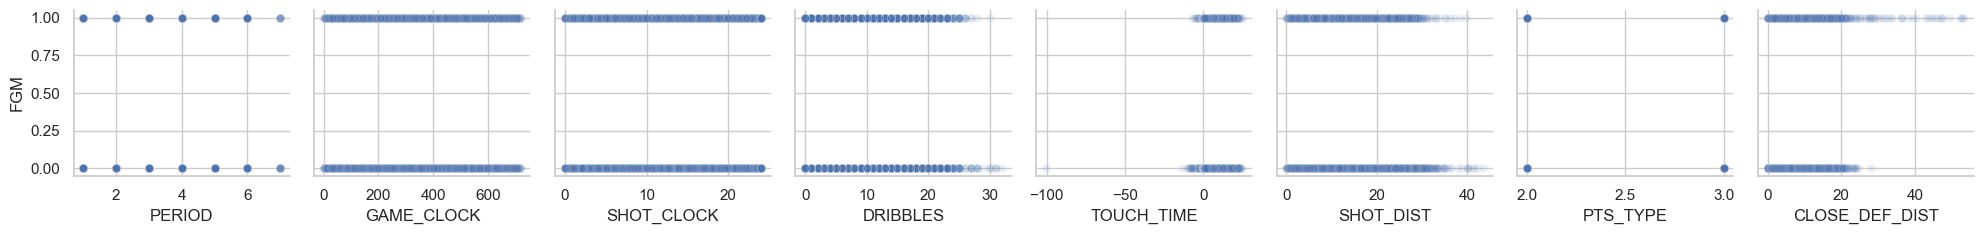

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_relation(X, y):
    sns.set(style="whitegrid", context="notebook")
    sns.pairplot(
        pd.concat([X, y], axis=1),
        x_vars=X.columns,
        y_vars=y.columns,
        size=2.5,
        plot_kws={"alpha": 0.1},
    )
    plt.tight_layout()
    plt.show()
    sns.reset_orig()


print("All attributes:")
plot_relation(X, y)

In [6]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.base import BaseEstimator


class InlierFilter(BaseEstimator):
    def __init__(self):
        super(InlierFilter, self).__init__()
        self.ransac = RANSACRegressor(
            LinearRegression(),
            max_trials=100,
            min_samples=50,
            residual_threshold=1.0,
            random_state=0,
        )
        self.inlier_mask_ = None

    def fit(self, X, y):
        self.ransac.fit(X, y)
        self.inlier_mask_ = self.ransac.inlier_mask_
        return self

    def transform(self, X):
        return X[self.inlier_mask_]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def print_info(self):
        print(
            "{:d}/{:d} (inliers/samples)".format(
                np.sum(self.inlier_mask_), len(y)
            )
        )


inlier_filter = InlierFilter().fit(X, y)
inlier_filter.print_info()
X_inliers = inlier_filter.transform(X)
y_inliers = y[inlier_filter.inlier_mask_]


85085/85751 (inliers/samples)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler().fit(X_inliers)
X_inliers_scaled = scaler_X.transform(X_inliers)
X_test_scaled = scaler_X.transform(X_test)

## 1. Model Choosing
Use all features to train [any linear model in scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#linear-models) and try different hyperparameters (ex. different degree, complexity). Show their performances.

### Linear Regression

degree: 1, mse train: 0.2342, val: 0.2340, accuracy train: 0.6087, val: 0.6076
degree: 2, mse train: 0.2311, val: 0.2306, accuracy train: 0.6167, val: 0.6146
degree: 3, mse train: 0.2297, val: 0.2299, accuracy train: 0.6194, val: 0.6169
degree: 4, mse train: 0.2281, val: 0.2322, accuracy train: 0.6227, val: 0.6157
degree: 5, mse train: 0.2253, val: 0.2666, accuracy train: 0.6263, val: 0.6149


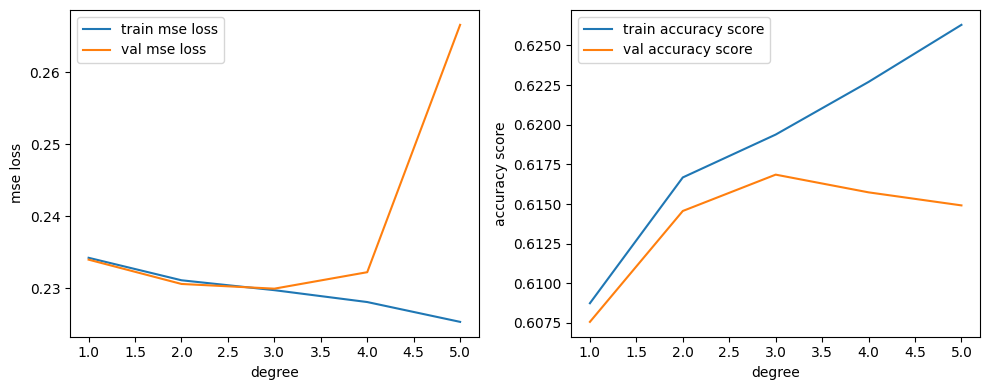

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


def linear(X, y):
    degrees = [1, 2, 3, 4, 5]
    train_mse_loss_list = []
    train_accuracy_score_list = []
    val_mse_loss_list = []
    val_accuracy_score_list = []

    for d in degrees:
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(X)
        X_train, X_val, y_train, y_val = train_test_split(
            X_poly, y, test_size=0.2, random_state=0
        )

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        train_mse_loss_list.append(mean_squared_error(y_train, y_train_pred))
        train_accuracy_score_list.append(
            accuracy_score(y_train, y_train_pred > 0.5)
        )
        val_mse_loss_list.append(mean_squared_error(y_val, y_val_pred))
        val_accuracy_score_list.append(accuracy_score(y_val, y_val_pred > 0.5))
        print(
            "degree: {:d}, mse train: {:.4f}, val: {:.4f}, accuracy train: {:.4f}, val: {:.4f}".format(
                d,
                train_mse_loss_list[-1],
                val_mse_loss_list[-1],
                train_accuracy_score_list[-1],
                val_accuracy_score_list[-1],
            )
        )

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.plot(degrees, train_mse_loss_list, label="train mse loss")
    plt.plot(degrees, val_mse_loss_list, label="val mse loss")
    plt.xlabel("degree")
    plt.ylabel("mse loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(degrees, train_accuracy_score_list, label="train accuracy score")
    plt.plot(degrees, val_accuracy_score_list, label="val accuracy score")
    plt.xlabel("degree")
    plt.ylabel("accuracy score")
    plt.legend()
    plt.tight_layout()
    plt.show()


linear(X_inliers_scaled, y_inliers)

### Ridge Regression

alpha:    0, mse train: 0.2298, val: 0.2300, accuracy train: 0.6198, val: 0.6166
alpha:    1, mse train: 0.2297, val: 0.2299, accuracy train: 0.6195, val: 0.6167
alpha:   10, mse train: 0.2297, val: 0.2299, accuracy train: 0.6195, val: 0.6168
alpha:  100, mse train: 0.2297, val: 0.2298, accuracy train: 0.6195, val: 0.6164
alpha: 1000, mse train: 0.2299, val: 0.2298, accuracy train: 0.6195, val: 0.6177
alpha: 10000, mse train: 0.2306, val: 0.2303, accuracy train: 0.6197, val: 0.6179


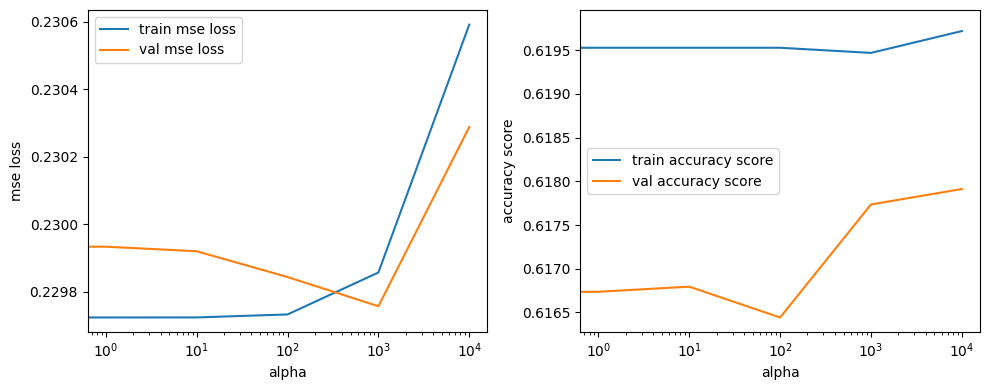

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def ridge(X, y, degree):
    alphas = [0, 1, 10, 100, 1000, 10000]
    train_mse_loss_list = []
    train_accuracy_score_list = []
    val_mse_loss_list = []
    val_accuracy_score_list = []

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(
        X_poly, y, test_size=0.2, random_state=0
    )

    for a in alphas:
        model = Ridge(alpha=a)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        train_mse_loss_list.append(mean_squared_error(y_train, y_train_pred))
        train_accuracy_score_list.append(
            accuracy_score(y_train, y_train_pred > 0.5)
        )
        val_mse_loss_list.append(mean_squared_error(y_val, y_val_pred))
        val_accuracy_score_list.append(accuracy_score(y_val, y_val_pred > 0.5))
        print(
            "alpha: {:4d}, mse train: {:.4f}, val: {:.4f}, accuracy train: {:.4f}, val: {:.4f}".format(
                a,
                train_mse_loss_list[-1],
                val_mse_loss_list[-1],
                train_accuracy_score_list[-1],
                val_accuracy_score_list[-1],
            )
        )

    plt.figure(figsize=(10, 4), dpi=100)
    ax = plt.subplot(1, 2, 1)
    ax.set_xscale("log")
    plt.plot(alphas, train_mse_loss_list, label="train mse loss")
    plt.plot(alphas, val_mse_loss_list, label="val mse loss")
    plt.xlabel("alpha")
    plt.ylabel("mse loss")
    plt.legend()
    ax = plt.subplot(1, 2, 2)
    ax.set_xscale("log")
    plt.plot(alphas, train_accuracy_score_list, label="train accuracy score")
    plt.plot(alphas, val_accuracy_score_list, label="val accuracy score")
    plt.xlabel("alpha")
    plt.ylabel("accuracy score")
    plt.legend()
    plt.tight_layout()
    plt.show()


ridge(X_inliers_scaled, y_inliers, 3)

### LASSO Regression

alpha: 0.0000, mse train: 0.2297, val: 0.2299, accuracy train: 0.6195, val: 0.6163
alpha: 0.0010, mse train: 0.2303, val: 0.2298, accuracy train: 0.6194, val: 0.6179
alpha: 0.0100, mse train: 0.2332, val: 0.2326, accuracy train: 0.6162, val: 0.6149
alpha: 0.1000, mse train: 0.2429, val: 0.2427, accuracy train: 0.5675, val: 0.5679
alpha: 1.0000, mse train: 0.2481, val: 0.2480, accuracy train: 0.5437, val: 0.5452
alpha: 10.0000, mse train: 0.2481, val: 0.2480, accuracy train: 0.5437, val: 0.5452


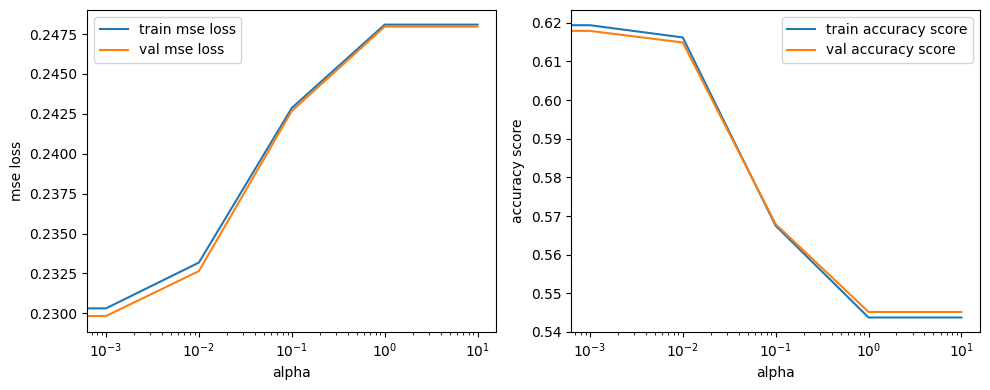

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt


def lasso(X, y, degree):
    alphas = [0, 0.001, 0.01, 0.1, 1, 10]
    train_mse_loss_list = []
    train_accuracy_score_list = []
    val_mse_loss_list = []
    val_accuracy_score_list = []

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(
        X_poly, y, test_size=0.2, random_state=0
    )

    for a in alphas:
        model = Lasso(alpha=a)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        train_mse_loss_list.append(mean_squared_error(y_train, y_train_pred))
        train_accuracy_score_list.append(
            accuracy_score(y_train, y_train_pred > 0.5)
        )
        val_mse_loss_list.append(mean_squared_error(y_val, y_val_pred))
        val_accuracy_score_list.append(accuracy_score(y_val, y_val_pred > 0.5))
        print(
            "alpha: {:2.4f}, mse train: {:.4f}, val: {:.4f}, accuracy train: {:.4f}, val: {:.4f}".format(
                a,
                train_mse_loss_list[-1],
                val_mse_loss_list[-1],
                train_accuracy_score_list[-1],
                val_accuracy_score_list[-1],
            )
        )

    plt.figure(figsize=(10, 4), dpi=100)
    ax = plt.subplot(1, 2, 1)
    ax.set_xscale("log")
    plt.plot(alphas, train_mse_loss_list, label="train mse loss")
    plt.plot(alphas, val_mse_loss_list, label="val mse loss")
    plt.xlabel("alpha")
    plt.ylabel("mse loss")
    plt.legend()
    ax = plt.subplot(1, 2, 2)
    ax.set_xscale("log")
    plt.plot(alphas, train_accuracy_score_list, label="train accuracy score")
    plt.plot(alphas, val_accuracy_score_list, label="val accuracy score")
    plt.xlabel("alpha")
    plt.ylabel("accuracy score")
    plt.legend()
    plt.tight_layout()
    plt.show()


lasso(X_inliers_scaled, y_inliers, 3)

## 2. Select model and plot error curve

Picked LASSO Regression as the model to use, with hyperparameter alpha=0.0010 and degree=3.

degree: 1, mse train: 0.2343, val: 0.2339, accuracy train: 0.6093, val: 0.6065
degree: 2, mse train: 0.2313, val: 0.2306, accuracy train: 0.6167, val: 0.6148
degree: 3, mse train: 0.2303, val: 0.2298, accuracy train: 0.6194, val: 0.6179
degree: 4, mse train: 0.2294, val: 0.2299, accuracy train: 0.6206, val: 0.6168
degree: 5, mse train: 0.2283, val: 0.2305, accuracy train: 0.6231, val: 0.6175


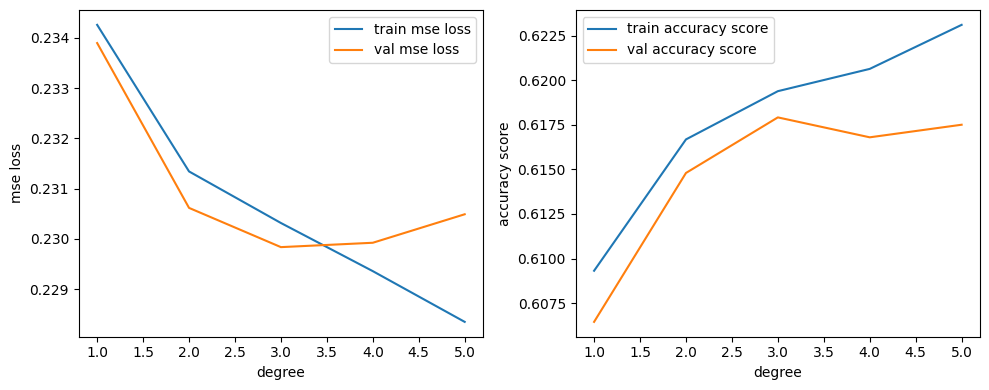

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt


def lasso(X, y, alpha):
    degrees = [1, 2, 3, 4, 5]
    train_mse_loss_list = []
    train_accuracy_score_list = []
    val_mse_loss_list = []
    val_accuracy_score_list = []

    for d in degrees:
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(X)
        X_train, X_val, y_train, y_val = train_test_split(
            X_poly, y, test_size=0.2, random_state=0
        )

        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        train_mse_loss_list.append(mean_squared_error(y_train, y_train_pred))
        train_accuracy_score_list.append(
            accuracy_score(y_train, y_train_pred > 0.5)
        )
        val_mse_loss_list.append(mean_squared_error(y_val, y_val_pred))
        val_accuracy_score_list.append(accuracy_score(y_val, y_val_pred > 0.5))
        print(
            "degree: {:d}, mse train: {:.4f}, val: {:.4f}, accuracy train: {:.4f}, val: {:.4f}".format(
                d,
                train_mse_loss_list[-1],
                val_mse_loss_list[-1],
                train_accuracy_score_list[-1],
                val_accuracy_score_list[-1],
            )
        )

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.plot(degrees, train_mse_loss_list, label="train mse loss")
    plt.plot(degrees, val_mse_loss_list, label="val mse loss")
    plt.xlabel("degree")
    plt.ylabel("mse loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(degrees, train_accuracy_score_list, label="train accuracy score")
    plt.plot(degrees, val_accuracy_score_list, label="val accuracy score")
    plt.xlabel("degree")
    plt.ylabel("accuracy score")
    plt.legend()
    plt.tight_layout()
    plt.show()


lasso(X_inliers_scaled, y_inliers, 0.001)

## 3. Feature Selection

Select features with the highest feature importance in random forest.

Top 3 important features: ['GAME_CLOCK' 'SHOT_DIST' 'SHOT_CLOCK']


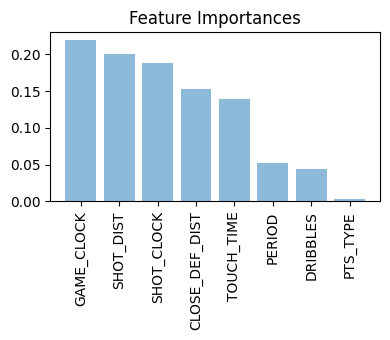

In [12]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator


class FeatureSelector(BaseEstimator):
    def __init__(self, num_features):
        self.num_features = num_features
        self.model = RandomForestRegressor(
            n_estimators=50, random_state=42, n_jobs=-1
        )
        self.indices_ = None

    def fit(self, X, y=None):
        self.model.fit(X, y)
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]
        self.indices_ = indices[: self.num_features]
        return self

    def transform(self, X):
        return X.iloc[:, self.indices_]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def get_feature_names(self, X):
        return X.columns[self.indices_]

    def plot_feature_importances(self):
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(4, 3.5), dpi=100)
        plt.title("Feature Importances")
        plt.bar(
            range(X.shape[1]), importances[indices], align="center", alpha=0.5
        )
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()


feature_selector = FeatureSelector(num_features=3).fit(X, y)
print("Top 3 important features:", feature_selector.get_feature_names(X).values)
feature_selector.plot_feature_importances()

X_top = feature_selector.transform(X)
X_top = pd.DataFrame(X_top, columns=feature_selector.get_feature_names(X))
y_top = y
X_test_top = feature_selector.transform(X_test)

Top attributes:


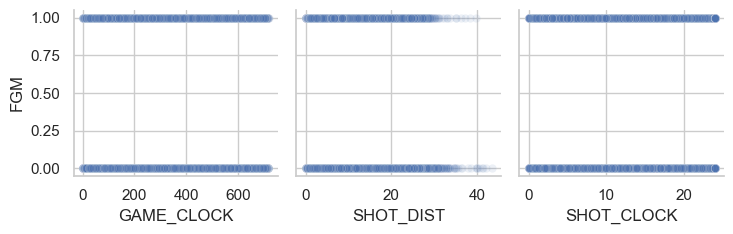

In [13]:
print("Top attributes:")
plot_relation(X_top, y)

In [14]:
from sklearn.preprocessing import StandardScaler

inlier_filter_top = InlierFilter().fit(X_top, y)
inlier_filter_top.print_info()
X_top_inliers = inlier_filter_top.transform(X_top)
y_top_inliers = y[inlier_filter_top.inlier_mask_]

scaler_X_top = StandardScaler().fit(X_top_inliers)
X_top_inliers_scaled = scaler_X_top.transform(X_top_inliers)
X_test_top_scaled = scaler_X_top.transform(X_test_top)

85751/85751 (inliers/samples)


## 4. Train the model with the selected features
Train the model with the only 3 features selected, and present the training error.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator


class PolyLasso(BaseEstimator):
    def __init__(self, alpha, degree):
        self.alpha = alpha
        self.degree = degree
        self.model = Lasso(alpha=alpha)
        self.poly = PolynomialFeatures(degree=degree)

    def fit(self, X, y):
        X_poly = self.poly.fit_transform(X)
        self.model.fit(X_poly, y)
        return self

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return self.model.predict(X_poly)

    def print_info(self, X, y):
        X_poly = self.poly.transform(X)
        y_pred = self.model.predict(X_poly)
        print(
            "mse: {:.4f}, accuracy: {:.4f}".format(
                mean_squared_error(y, y_pred),
                accuracy_score(y, y_pred > 0.5),
            )
        )


poly_lasso = PolyLasso(alpha=0.001, degree=3).fit(
    X_top_inliers_scaled, y_top_inliers
)
poly_lasso.print_info(X_top_inliers_scaled, y_top_inliers)

mse: 0.2366, accuracy: 0.6091


## 5. Export the predictions

In [16]:
import pandas as pd

y_test_pred = (poly_lasso.predict(X_test_top_scaled) > 0.5).astype(int)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=y.columns)
y_test_pred_df.to_csv("data/y_test.csv", index=False)

## 6. Report

### Input

First, we load the data and preprocess it. We can see that y is binary, so we can use either regression or classification models. I chose to use regression models for this assignment.

Then I plot the correlation matrix to see the relationship between features and the target but it seems that there is no strong correlation between them.

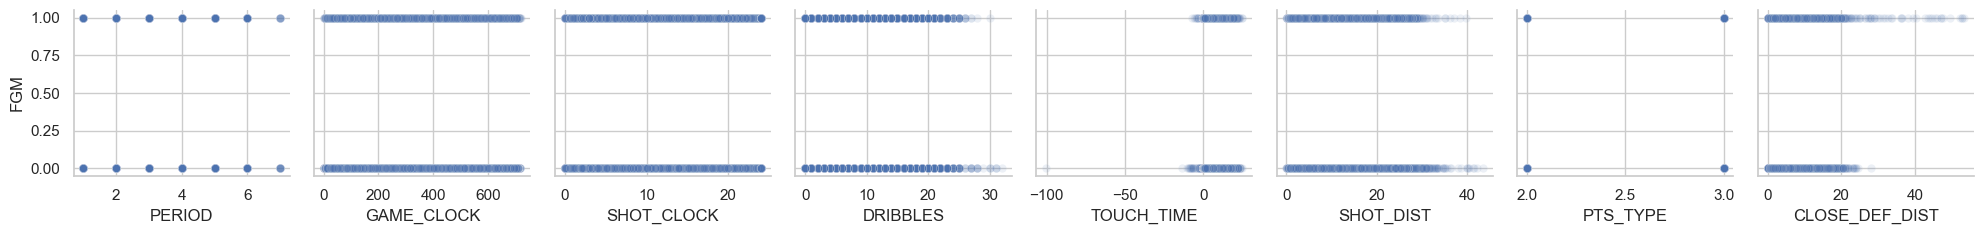

I perform outliers detection and remove the outliers from the data with `RANSACRegressor`, and I scale the data using `StandardScaler`.

### Model Choosing

I tried Linear Regression, Ridge Regression, and Lasso Regression with different hyperparameters. Before training the models, I split the data into training and validation sets. The validation set is used to evaluate the performance of the models.

With Linear Regression, I observed that the model reached best performance with degree=3.

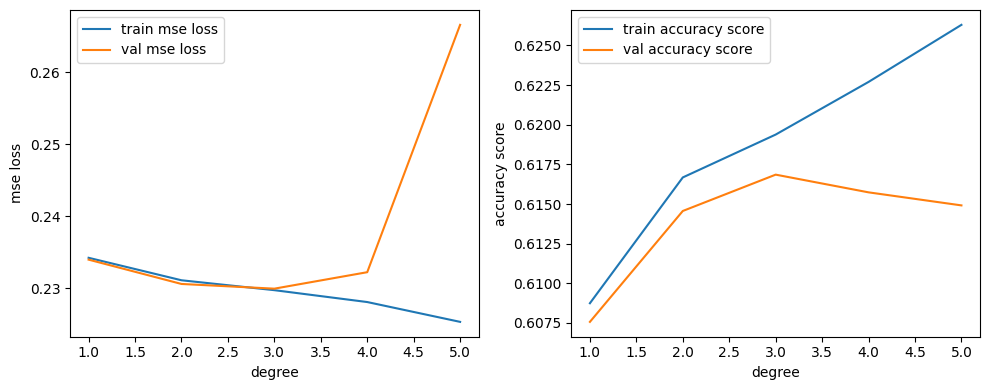

Then I tried Ridge and Lasso Regression with different hyperparameters. The best performance is achieved by Lasso Regression with alpha=0.0010 and degree=3.

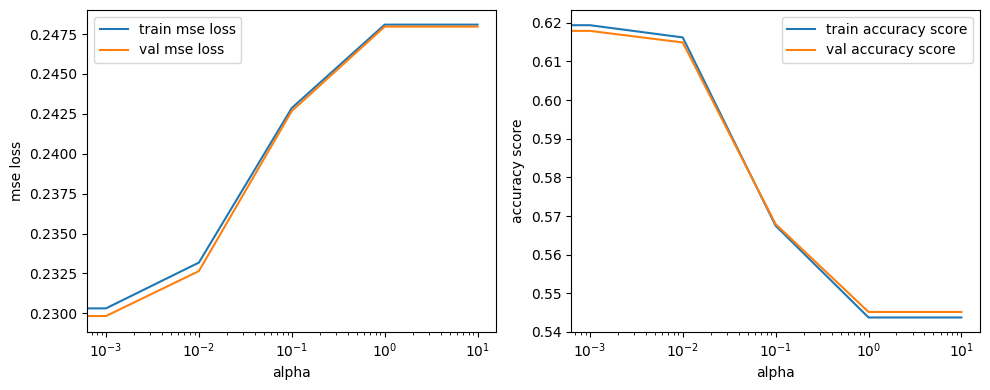

### Error Curve

I plotted the error curve of the Lasso Regression model with alpha=0.0010 with different degrees. The error curve shows that the model isn't overfitting at degree=3.

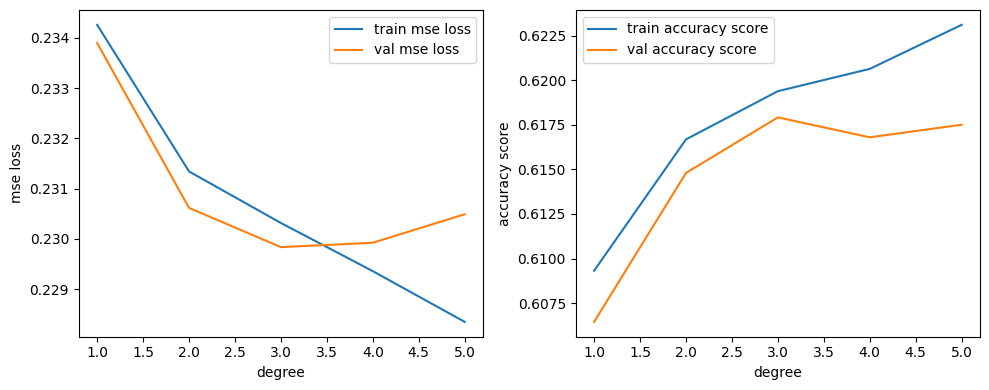

### Feature Selection

I used Random Forest to select the best 3 features that can best aid the model's prediction. The selected features are `GAME_CLOCK`, `SHOT_DIST`, and `SHOT_CLOCK`.

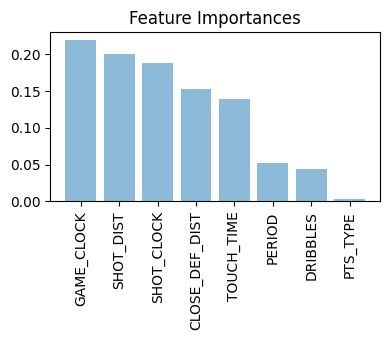

The training mean squared error of the model with the selected features is 0.2366.
